# Vectorize BoW
<div style="position: absolute; right:0;top:0"><a href="./vectorizer_index.doc.ipynb" style="text-decoration: none"> <font size="5">←</font></a>
<a href="../evaluation.ipynb" style="text-decoration: none"> <font size="5">↑</font></a></div>

`Description`

---
## Setup and Settings
---

In [1]:
from __init__ import init_vars
init_vars(vars(), ('info', {}), ('runvars', {}), ('num_docs', 200), ('num_words', 400))

import numpy as np
from scipy import sparse
from collections import Counter

import data
import config
from base import nbprint
from util import ProgressIterator
from widgetbase import nbbox

from tokenizer.common import split_tokens

from vectorizer.widgets import bow_vector_picker
from vectorizer.plots import plot_matrix

if RUN_SCRIPT: bow_vector_picker(info)

Data Name,ACM (exists)
Token Version,B0 (exists)
Vocab Version,B0 (exists)
Vector,missing
Version,B0
TF,raw
IDF,unary


FloatProgress(value=0.0, bar_style='info', layout=Layout(visibility='hidden'), max=1.0, style=ProgressStyle(de…

---
## Term-Doc Mat
---
### Count Tokens and build matrix
Loads tokenized data and creates a sparse matrix of size number-of-terms by number-of-documents containing absolute counts as entries. Excludes empty documents and stores the ids of the documents in the matrix.

In [2]:
def make_term_doc_mat_count(info, runvars):
    counts, i, j, mat_ids = [], [], [], []
    idx, excluded = 0, 0
    vocab = data.load_vocab_dict(info)
    
    with data.tokenized_document_reader(info) as documents:
        for document in ProgressIterator(documents, 'Documents'):
            tokens = split_tokens(document['tokens'])
            tokencnt = Counter(tokens).most_common()
            num_tokens = 0
            for token, count in tokencnt:
                if token in vocab:
                    counts.append(count)
                    i.append(vocab[token]['id'])
                    j.append(idx)
                    num_tokens += count
            if num_tokens > 0:
                idx += 1
                mat_ids.append(document['id'])
            else:
                excluded += 1
    nbprint("Documents {}, Excluded {} empty documents".format(idx, excluded))
    term_doc_mat_shape = (len(vocab), idx)
    runvars['term_doc_mat_count'] = sparse.coo_matrix((counts, (i, j)), shape=term_doc_mat_shape).tocsc()
    runvars['mat_ids'] = mat_ids
if RUN_SCRIPT:
    nbbox(mini=True)
    make_term_doc_mat_count(info, runvars)


Documents 36396, Excluded 0 empty documents  


FloatProgress(value=0.0, bar_style='info', layout=Layout(visibility='hidden'), max=1.0, style=ProgressStyle(de…

### Term Frequency Matrix

Build TF matrix $X$ from count matrix $C$.

- `raw`: Counts as integer values
$$X_{i\,j} = C_{i\,j}$$
- `normalized`: Normalize columns to sum to one
$$X_{i\,j} = \frac{1}{\sum_k C_{k\,j}} C_{i\,j}$$
- `boolean`: Entries are zero or one
$$X_{i\,j} = \begin{cases}
1 & C_{i\,j} > 0 \\
0 & \text{else}
\end{cases}$$
- `log`: Take the logarithm of the counts (plus one to avoid zero logarithm)
$$X_{i\,j} = \log(C_{i\,j} + 1)$$

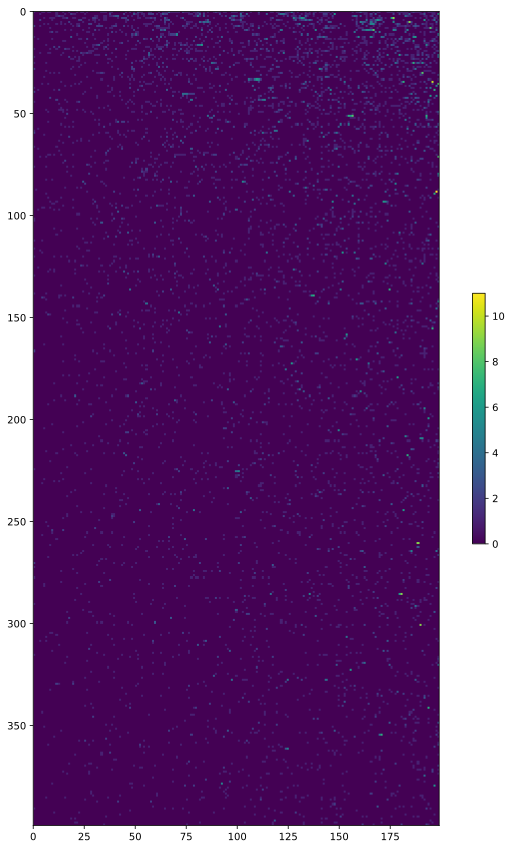

In [3]:
def make_term_doc_mat_tf(info, runvars):
    term_doc_mat_count = runvars['term_doc_mat_count']
    if info['vector_info']['tf'] == "raw":
        term_doc_mat_tf = term_doc_mat_count.copy()
    elif info['vector_info']["tf"] == "normalized":
        term_doc_mat_tf = term_doc_mat_count.copy()
        column_sum = np.squeeze(np.asarray(
            term_doc_mat_count.sum(axis=0)))
        normalization = sparse.diags(1/column_sum)
        term_doc_mat_tf = term_doc_mat_tf * normalization
    elif info['vector_info']["tf"] == "boolean":
        term_doc_mat_tf = 1*(term_doc_mat_count > 0)
    elif info['vector_info']["tf"] == "log":
        term_doc_mat_tf = term_doc_mat_count.copy()
        term_doc_mat_tf.data = np.log(term_doc_mat_tf.data + 1)
    runvars['term_doc_mat_tf'] = term_doc_mat_tf
if RUN_SCRIPT:
    make_term_doc_mat_tf(info, runvars)
    plot_matrix(runvars['term_doc_mat_tf'][1:num_words,1:num_docs])

### Inverse Document Frequency Matrix

Multiply the TF by the IDF matrix $I$ element wise.

- `unary`: IDF matrix is all ones
$$I_{i\,j} = 1$$
- `idf`: logarithm

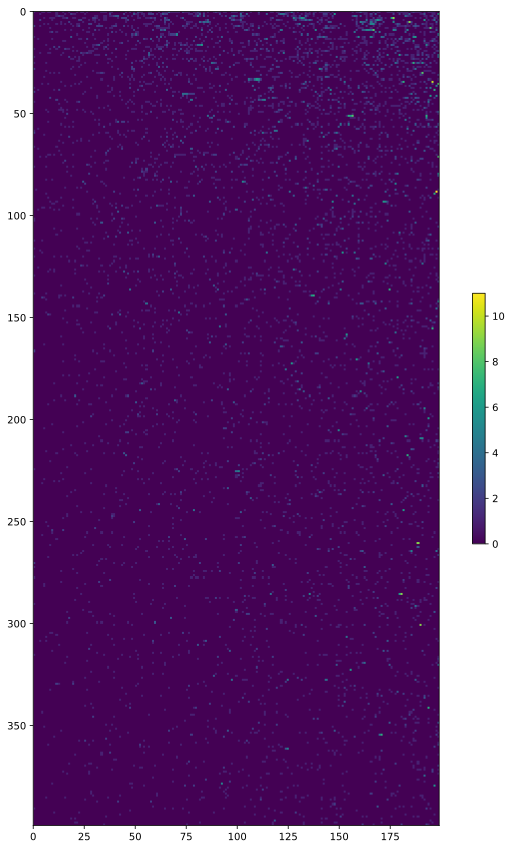

In [5]:
def make_term_doc_mat_idf(info, runvars):
    term_doc_mat_tf = runvars['term_doc_mat_tf']
    if info['vector_info']["idf"] == "unary":
        term_doc_mat_tf_idf = term_doc_mat_tf
    elif info['vector_info']["idf"] == "idf":
        word_occurence = np.squeeze(np.asarray(
            runvars['term_doc_mat_count'].sum(axis=1)))
        total_words = word_occurence.sum()
        idf = sparse.diags(np.log(total_words / word_occurence), format='csc')
        term_doc_mat_tf_idf = idf * term_doc_mat_tf
    runvars['term_doc_mat_tf_idf'] = term_doc_mat_tf_idf.tocsc()
if RUN_SCRIPT:
    make_term_doc_mat_idf(info, runvars)
    plot_matrix(runvars['term_doc_mat_tf_idf'][1:num_words,1:num_docs])

---
## Build complete tokenizer function
---

In [6]:
def make_term_doc_mat_tf_idf(info, runvars):
    make_term_doc_mat_tf(info, runvars)
    make_term_doc_mat_idf(info, runvars)